<a href="https://colab.research.google.com/github/Trushali29/BookRecommendation/blob/main/book2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

popularity based -- input from bookName and number.

by author -- input author name from dataset1.

by publisher -- input author name from dataset1.

popularity threshold dataset for content, collaborative and hybrid take inputs from there.

KNN input from dataset1.

for hybrid first run content and collaborative and take number input which was initialli defined.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive' ,force_remount=True)

Mounted at /content/gdrive


**Importing all the required packages**

In [ ]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

**IMPORTING THE DATASET **

In [ ]:
books = pd.read_csv("/content/gdrive/MyDrive/GROUP PROJECTS/AMT PAPERS/Books.csv", delimiter=',',error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv("/content/gdrive/MyDrive/GROUP PROJECTS/AMT PAPERS/Ratings.csv",delimiter=',',error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv("/content/gdrive/MyDrive/GROUP PROJECTS/AMT PAPERS/Users.csv",delimiter=',',error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis='columns', inplace=True)
books.tail()

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press
271359,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages


In [ ]:
users.head()


,User-ID,Location,Age
0,1,"nyc, new york, usa",35
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",35
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",35


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## book dataset preprocessing

In [ ]:
print("Columns: ", list(books.columns))

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']


In [ ]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [ ]:
## Checking for null values
books.loc[books['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [ ]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [ ]:
books.at[187689 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [ ]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
pd.set_option('display.max_colwidth', -1)
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [ ]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?ÃÂ©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [ ]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[221678 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[221678 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[220731 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[220731 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [ ]:
books.loc[books['Book-Title'] == 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc


In [ ]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
print(sorted(list(books['Year-Of-Publication'].unique())))

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021]


In [ ]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]
print(count)

Counter({2002: 22258, 1999: 17431, 2001: 17359, 2000: 17234, 1998: 15766, 1997: 14890, 2003: 14359, 1996: 14030, 1995: 13546, 1994: 11796, 1993: 10602, 1992: 9906, 1991: 9389, 1990: 8660, 1989: 7936, 1988: 7492, 1987: 6529, 1986: 5841, 2004: 5839, 1985: 5343, 1984: 4986, 1983: 4499, 1982: 4197, 1981: 3279, 1980: 2676, 1979: 2208, 1978: 2131, 1977: 1897, 1976: 1597, 1975: 1219, 1974: 1023, 1973: 923, 1972: 772, 1971: 540, 1970: 459, 1969: 339, 1968: 233, 1966: 183, 1967: 176, 1965: 173, 1964: 149, 1960: 133, 1961: 132, 1963: 132, 1962: 123, 1959: 103, 1958: 77, 1957: 76, 1956: 74, 1955: 70, 1953: 63, 1954: 54, 2005: 46, 1951: 40, 1940: 36, 1952: 34, 1920: 33, 1950: 32, 1911: 19, 1942: 14, 1947: 14, 1946: 13, 1930: 13, 1923: 11, 1949: 11, 1941: 10, 1948: 9, 1939: 9, 1943: 8, 1945: 8, 1936: 7, 1938: 7, 1929: 7, 1901: 7, 1937: 5, 1932: 5, 1933: 4, 1944: 4, 2020: 3, 1931: 3, 1900: 3, 1935: 3, 2006: 3, 2011: 2, 1925: 2, 1926: 2, 1928: 2, 1927: 2, 1902: 2, 1924: 2, 1921: 2, 2010: 2, 1909: 2, 

In [ ]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002


In [ ]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True)
books.reset_index(drop = True, inplace = True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


user datset preprocessing

In [ ]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
## Checking null values
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [ ]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [ ]:
required = users[users['Age'] <= 80]
#print(len(required))
required = required[required['Age'] >= 10]
#print(len(required))
mean = round(required['Age'].mean())
mean

35

In [ ]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [ ]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       278858 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.4+ MB


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",35
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",35
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",35


Rating datset preprocessing

In [ ]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
## Checking for null values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True
True


In [ ]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [ ]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


merge all the three tables

In [ ]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Location             1031609 non-null  object
 8   Age                  1031609 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 78.7+ MB


In [ ]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 9)

In [ ]:
dataset1.head(30)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,"timmins, ontario, canada",35
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,"timmins, ontario, canada",35
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,"timmins, ontario, canada",35
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,"timmins, ontario, canada",35
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,"timmins, ontario, canada",35
5,1575663937,More Cunning Than Man: A Social History of Rats and Man,Robert Hendrickson,1999,Kensington Publishing Corp.,8,6,"timmins, ontario, canada",35
6,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,8,7,"timmins, ontario, canada",35
7,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,11400,9,"ottawa, ontario, canada",49
8,0151008116,Life of Pi,Yann Martel,2002,Harcourt,11400,6,"ottawa, ontario, canada",49
9,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,11400,7,"ottawa, ontario, canada",49


In [ ]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 9)

In [ ]:
dataset2.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,"stockton, california, usa",18
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,0,"timmins, ontario, canada",35
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,8,0,"timmins, ontario, canada",35
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",35
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,8,0,"timmins, ontario, canada",35


##Data Visualization


No. of books by author (Top 15)

Text(0.5, 1.0, 'No of books by an author (Top 15)')

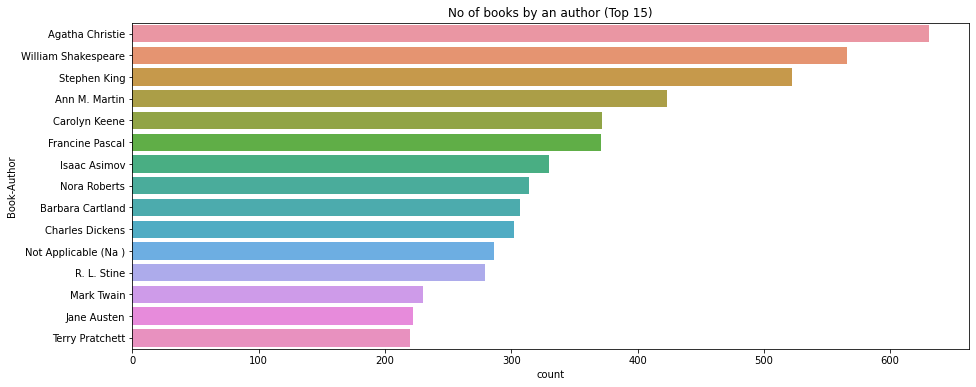

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")


No. of books by publisher (Top 15)


Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

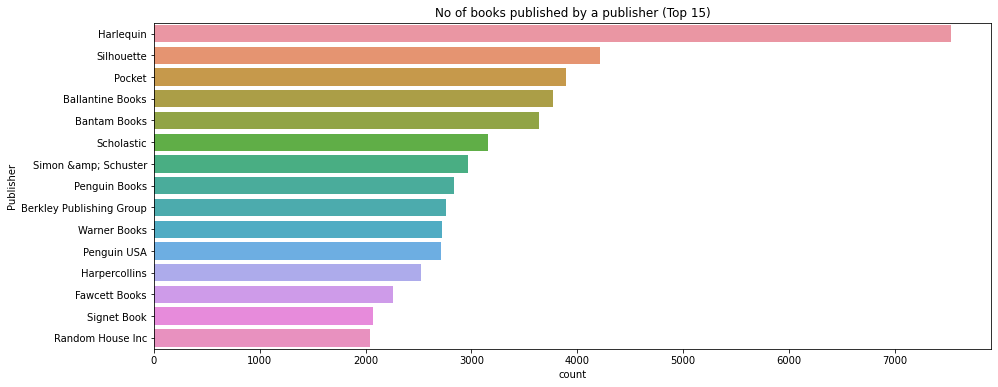

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")


Explicit book ratings


Text(0.5, 1.0, 'Explicit Ratings')

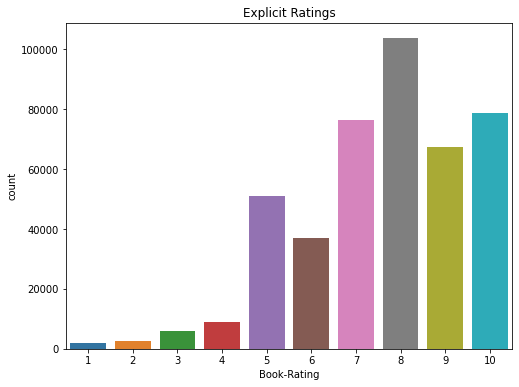

In [ ]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")


Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

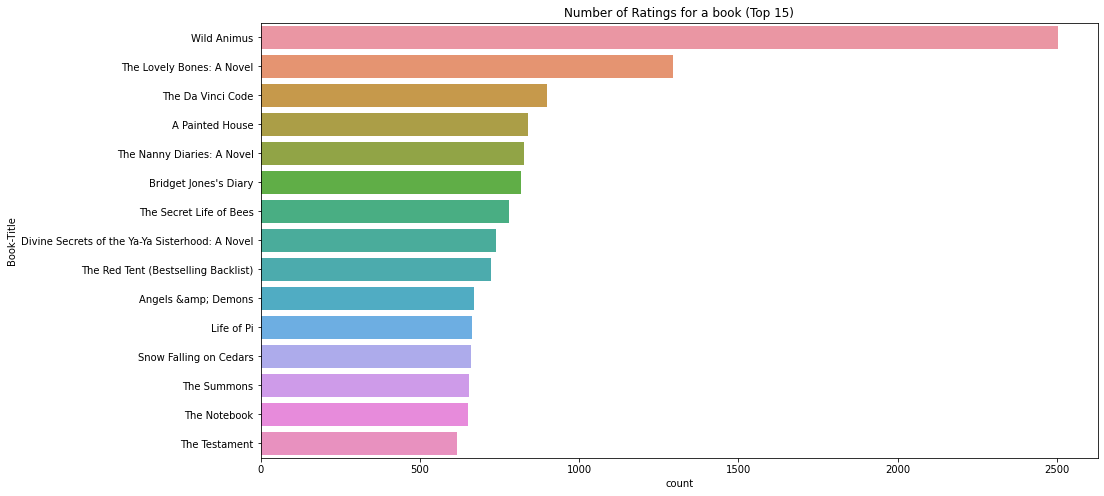

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

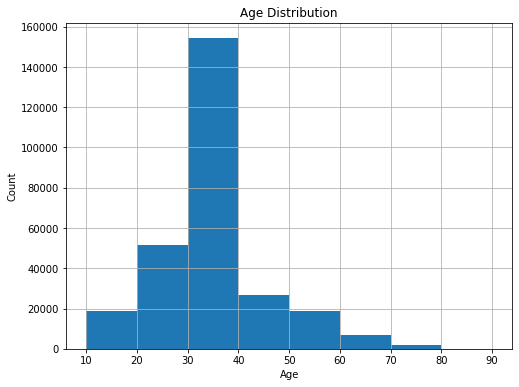

In [ ]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Implicit book ratings


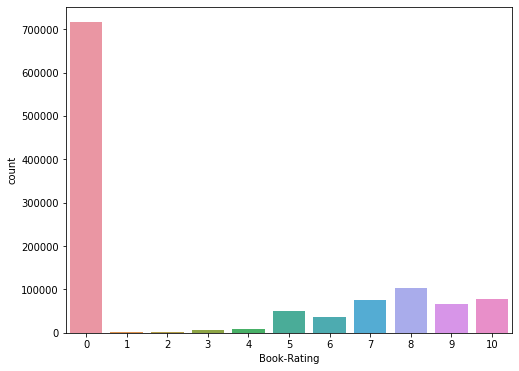

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

input variables

In [ ]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))
# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: Life of Pi
Enter number of books to recommend: 5


## popularity based top in whole collection

In [ ]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        #print(data)
        result = pd.merge(data, books, on='ISBN',how="inner")
        return result
    return "Invalid number of books entered!!"
Popularity_N = int(input("Enter a value: "))
print("Top", Popularity_N, "Popular books are: ")
popularity_based(dataset1, Popularity_N)

Enter a value: 10
Top 10 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
5,059035342X,315,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
6,0142001740,314,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
7,0446672211,295,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
8,044023722X,282,A Painted House,John Grisham,2001,Dell Publishing Company
9,0452282152,278,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


## books by author

In [ ]:
# RECOMMENDATIONS BY SEARCH
# based on the author name the user likes recommend it's books to user
# recommend books authorname-books
def RecommendBooksByAuthor(author_name):
  author_name = author_name.strip()
  index = list(np.where(author_name == dataset1['Book-Author'],dataset1['Book-Title'],'nan'))
  Book_list = []
  for i in index :
      if i != 'nan'and i not in Book_list:
        Book_list.append(i)
  for b in Book_list:
   print(b)

print("Book by Author name: ")
author_name = str(input("Enter the Author Name: "))
RecommendBooksByAuthor(author_name)

Book by Author name: 
Enter the Author Name: Alice Sebold
The Lovely Bones: A Novel
The Lovely Bones
Lucky
Lucky : A Memoir
Desde Mi Cielo


## books by publisher

In [ ]:
def RecommendBooksByPublisher(Publisher_name):
  Publisher_name = Publisher_name.strip()
  index = list(np.where(Publisher_name == dataset1['Publisher'],dataset1['Book-Title'],'nan'))
  Book_list = []
  for i in index:
      if i != 'nan' and i not in Book_list:
        Book_list.append(i)
  for b in Book_list:
   print(b)
print("Book by Publisher_name: ")
Publisher_name = str(input("Enter the Publisher Name: "))
RecommendBooksByPublisher(Publisher_name)


Book by Publisher_name: 
Enter the Publisher Name: Little, Brown
The Pilot's Wife : A Novel Tag: Author of the Weight of Water (Oprah's Book Club (Hardcover))
The Big Bad Wolf: A Novel
Four Blind Mice
The Weight of Water
The Lovely Bones: A Novel
Suzanne's Diary for Nicholas
2nd Chance
All Too Human : A Political Education
Johnny Long Legs (Matt Christopher Sports Classics)
White Oleander : A Novel
The Dogs of Babel (Today Show Book Club #12)
The Tipping Point: How Little Things Can Make a Big Difference
Sea Glass: A Novel
Revolution from Within : A Book of Self-Esteem
Violets Are Blue
Sam's Letters to Jennifer
The Lake House
The Last Time They Met : A Novel
Tangled Vines
3rd Degree
The Gift of Fear : Survival Signals That Protect Us from Violence
A Question of Blood: An Inspector Rebus Novel
River, Cross My Heart : A Novel
Blood Work (Blood Work)
Chasing the Dime
Me Talk Pretty One Day
Lost Light
Fortune's Rocks : A Novel
The Castafiore Emerald (The Adventures of Tintin)
The Narrows: 

Creating popular book dataset from books dataset for further recommendations

In [ ]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
print(df)
df['Total-Ratings'] = df['Book-Title']

df['Book-Title'] = df.index
print(df.head())
df.reset_index(level=0, inplace=True)
print(df.head())
df = df.drop('index',axis=1)
print(df.head())
df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','Location'], axis=1)

                                                                      Book-Title
The Lovely Bones: A Novel                                             707       
Wild Animus                                                           581       
The Da Vinci Code                                                     495       
The Secret Life of Bees                                               413       
The Nanny Diaries: A Novel                                            393       
...                                                                   ...       
Pearl Buck's the Good Earth                                           1         
Pearl S. Buck's Book of Christmas (G K Hall Large Print Book Series)  1         
Pearl S. Buck, the Story Bible                                        1         
Mrs. Malory and Death in Practice (Sheila Malory Mysteries)           1         
Anglo-American Cataloguing Rules                                      1         

[135591 rows x 1 columns]
 

In [ ]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 6)

In [ ]:
popular_book.head(20)

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,Total-Ratings
0,0786868716,The Five People You Meet in Heaven,Mitch Albom,11400,9,244
1,0151008116,Life of Pi,Yann Martel,11400,6,337
2,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,11400,7,383
3,014025448X,At Home in Mitford (The Mitford Years),Jan Karon,11400,10,99
4,0743418174,Good in Bed,Jennifer Weiner,11400,8,247
5,0060958022,Five Quarters of the Orange,Joanne Harris,11400,10,97
6,0440222656,The Horse Whisperer,Nicholas Evans,11400,6,182
7,0399135782,The Kitchen God's Wife,Amy Tan,11676,9,116
8,0440234743,The Testament,John Grisham,11676,9,261
9,0971880107,Wild Animus,Rich Shapero,11676,6,581


## *content* Filtering

In [ ]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [ ]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [ ]:

number1 = int(input("Enter Number of Books : \n"))
print("Enter the Book name :\n")
bookName1= str(input())
isbn = books.loc[books['Book-Title'] == bookName1].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName1 and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number1:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Enter Number of Books : 
10
Enter the Book name :

Life of Pi
The Secret Life of Bees
Wicked: The Life and Times of the Wicked Witch of the West
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson
Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life
Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)
From the Corner of His Eye
A Wrinkle in Time
Sphere
The Door to December
The Girls' Guide to Hunting and Fishing


## **Collaborative filtering **

User - Item Collaborative Filtering

In [ ]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])

    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset1['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")


def getTopRecommandations(bookID):
    collaborative = []
    print("Bookid",type(bookID))
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)

    print("\nRECOMMENDATIONS:\n")

    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=collab_number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])
collab_bookname = input(str("Enter a book name: \n")).strip()
collab_number = int(input("Enter Number of Books : \n"))
collaborative = getTopRecommandations(m[k.index(collab_bookname)])


Enter a book name: 
Life of Pi
Enter Number of Books : 
10
Bookid <class 'str'>
Input Book:
Life of Pi
Title: Life of Pi
Author: Yann Martel



RECOMMENDATIONS:

Fahrenheit 451
Title: Fahrenheit 451
Author: Ray Bradbury


The Summons
Title: The Summons
Author: John Grisham


A Widow for One Year
Title: A Widow for One Year
Author: John Irving


Deception Point
Title: Deception Point
Author: Dan Brown


Sea Glass: A Novel
Title: Sea Glass: A Novel
Author: Anita Shreve


The Pillars of the Earth
Title: The Pillars of the Earth
Author: Ken Follett


Quentins
Title: Quentins
Author: Maeve Binchy


Fried Green Tomatoes at the Whistle Stop Cafe
Title: Fried Green Tomatoes at the Whistle Stop Cafe
Author: Fannie Flagg


From the Corner of His Eye
Title: From the Corner of His Eye
Author: DEAN KOONTZ


Middlesex: A Novel
Title: Middlesex: A Novel
Author: Jeffrey Eugenides




## KNN based recommendation

In [ ]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title',  how = "inner")
result = result[result['Total-Rating'] >= 50]
result = result.reset_index(drop = True)
result[100:110]
#result.shape
matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating')
matrix.fillna(0,inplace=True)
matrix.head(20)
up_matrix = csr_matrix(matrix)


In [ ]:
matrix[400:410]

User-ID,9,16,26,32,42,51,91,97,99,114,...,278800,278807,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sleep No More,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Slow Waltz in Cedar Bend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Smilla's Sense of Snow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snow Falling on Cedars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sole Survivor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Song of Solomon (Oprah's Book Club (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Songs in Ordinary Time (Oprah's Book Club (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sophie's World: A Novel About the History of Philosophy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# give name of those book whose book - ratings is more then 8
bookName2 = "The Dark Half"
# provides
number = 6
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName2].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

Four Past Midnight
The Tommyknockers
Nightmares &amp; Dreamscapes
Carrie
Skeleton Crew
Misery


## Hybrid (content+collaborative) filtering

In [ ]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Life of Pi

Recommended Books:

Confessions of a Shopaholic (Summer Display Opportunity)
How to Be Good
In Her Shoes : A Novel
Good Omens
Shopaholic Takes Manhattan (Summer Display Opportunity)
Midnight in the Garden of Good and Evil: A Savannah Story
